In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

os.chdir('../')
%matplotlib inline

In [2]:
import wandb
wandb.login()

wandb: Currently logged in as: ernestoserize (ernestoserize-constructor-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [5]:
data = pd.read_csv('data/raw/data.csv')

### The dataset is imbalanced

* 78.5% of patients were deceased (0)

* 21.5% were alive (1) at discharge.

We’ll handle this imbalance carefully in the model training step using:

* Stratified splitting

* Possibly class weights or resampling techniques

In [3]:
data['discharge_status'].value_counts()

discharge_status
0    84
1    23
Name: count, dtype: int64

### LGI Distribution and Outliers

The LGI distribution exhibited a positive skew (right skew), with most values concentrated between 500 and 2500. As ILG increases, the frequency of patients with high values decreases, suggesting the presence of outliers in the right tail of the distribution.

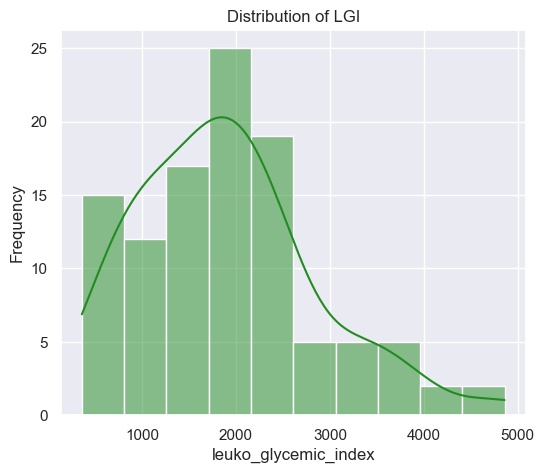

In [4]:
plt.figure(figsize=(6,5))
sns.set(style='darkgrid')
sns.histplot(data['leuko_glycemic_index'], color='forestgreen', kde=True)
plt.title('Distribution of LGI')
plt.ylabel('Frequency')
plt.show()

### Analyzing outliers

Given that the dataset consists of only 107 cases, the removal of extreme values could significantly affect the model’s generalization capacity. In this context, outliers were retained whenever they had clinical justification. Specifically, high LGI values could correspond to critically ill patients, making them relevant for analysis.

However, a single case where LGI exceeded 4500 and the patient survived  was removed to prevent excessive skewing.

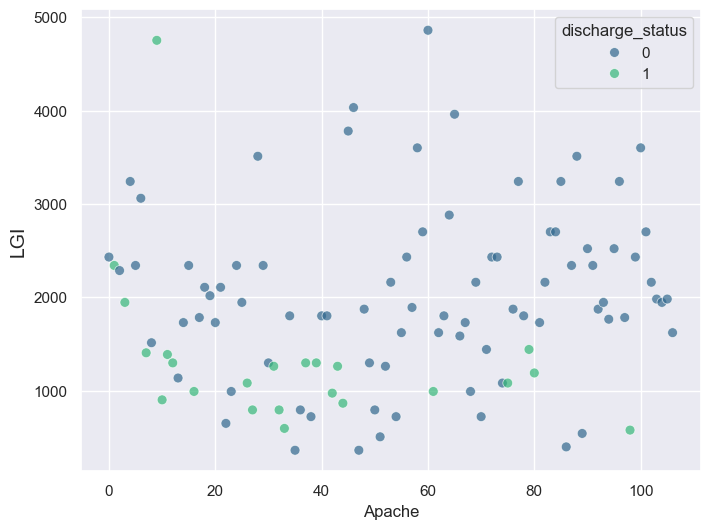

In [5]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data.index, y='leuko_glycemic_index', data=data, hue='discharge_status', alpha=0.7, palette='viridis', s=50)
plt.ylabel('LGI', fontsize=14)
plt.xlabel('Apache')
plt.show()

In [6]:
data.drop(data[ (data['leuko_glycemic_index'] > 4500)].index, axis=0, inplace=True)

Here, we drop these columns since the LGI is the result of multiplying leukocytes and glycemic

In [7]:
data.columns

Index(['age', 'sex', 'consciousness_disorder', 'apache_score', 'leukocytes',
       'glucose', 'glucose_mg_dl', 'leuko_glycemic_index', 'discharge_status',
       'ischemic_stroke_no_sequelae', 'hypertension', 'diabetes_mellitus',
       'gouty_arthritis', 'prostate_adenocarcinoma_surgery',
       'previous_health_status', 'schizophrenia', 'ovarian_tumor',
       'ischemic_heart_disease', 'cataracts', 'arthritis',
       'atrial_fibrillation', 'chronic_kidney_disease', 'glaucoma', 'copd',
       'chronic_hepatitis', 'sleep_apnea', 'hypothyroidism',
       'deep_venous_insufficiency', 'hepatitis_c', 'migraine_headache',
       'heart_failure', 'peripheral_venous_insufficiency',
       'nosocomial_pneumonia', 'bronchopneumonia', 'acute_respiratory_failure',
       'neurogenic_shock', 'seizures', 'hyperglycemia', 'aspiration_pneumonia',
       'hypernatremia', 'normal_pressure_hydrocephalus',
       'nosocomial_pneumonia_bnb', 'septic_shock', 'intravascular_sepsis',
       'pulmonary_hype

In [8]:
drops= ['leukocytes', 'glucose', 'glucose_mg_dl']
data.drop(columns=drops, axis=1, inplace=True)

In [9]:
X, y = data.drop('discharge_status', axis=1), data['discharge_status']

### Feature Selection

* Variance thresholding analysis 
* SeleckKBest in conjunction with the chi-squared (χ²) 
* Correlation matrix analysis

In [10]:
variances = X.var(axis=0)
ind = variances[variances > 0.2].index
X = X[ind]

In [11]:
matrix = X.join(y).corr()
mask = np.triu(np.ones_like(matrix, dtype=bool))

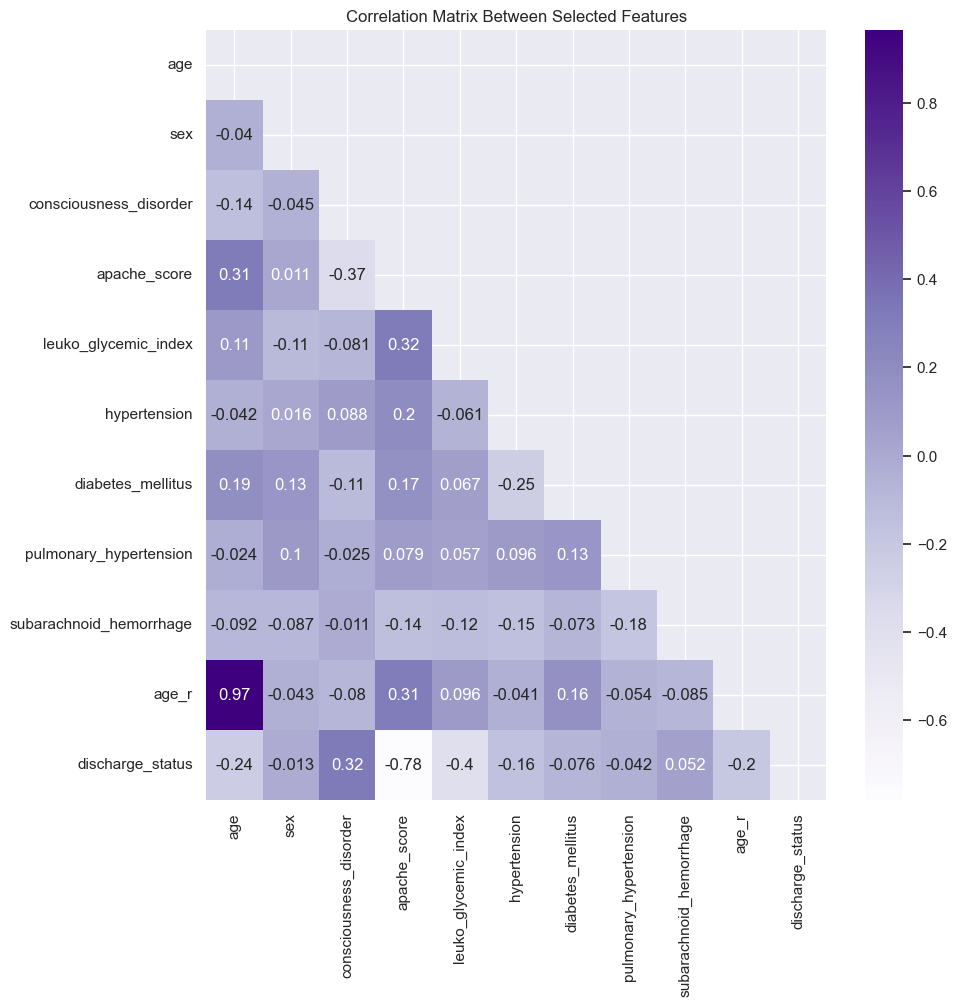

In [16]:
plt.figure(figsize=(10, 10))
sns.heatmap(matrix, annot=True, cmap='Purples', mask=mask)
plt.title('Correlation Matrix Between Selected Features')
plt.show()

In [13]:
from sklearn.feature_selection import SelectKBest, chi2

selector = SelectKBest(score_func=chi2, k=2)

selector.fit_transform(X, y)

features = X.columns[selector.get_support(indices=True)]
features

Index(['apache_score', 'leuko_glycemic_index'], dtype='object')

In [14]:
X = X[features]

In [15]:
data = X.join(y).to_csv('data/selected/data.csv', index=False)